In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import h5py

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Ariel']
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '25'
mpl.rcParams['ytick.labelsize'] = '25'

In [2]:
files = glob.glob('SN2011fe_syn/11fe*')
files.sort()

# SN 2011fe

## Spectra

In [3]:
f = files[0]
hdul = fits.open(f)
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 2691                                                  
EXTEND  =                    T                                                  
CRPIX1  =                    1 / reference pixel                                
CRVAL1  =              3298.68 / coordinate at reference pixel                  
CDELT1  =                 2.38 / coordinate increment per pixel                 
CUNIT1  = 'Angstrom'           / coordinate units                               
CTYPE1  = 'LINEAR  '                                                            
OBJECT  = 'SN2011fe'           / object name                                    
RA      = '14:03:05.73'        / object right ascension                         
DEC     = '54:16:25.18'     

In [4]:
f = files[8]
hdul = fits.open(f)
hdr = hdul[0].header
phase = hdr['tmax']
fl, sig = hdul[0].data, hdul[1].data**.5
wav = np.arange(len(fl)) * float(hdr['CDELT1']) + float(hdr['CRVAL1'])
spec = np.array([wav, fl, sig])

## Filters

In [5]:
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')
P48i = np.loadtxt('P48_I.dat')
SDSSg = np.loadtxt('SLOAN_SDSS.g.dat')

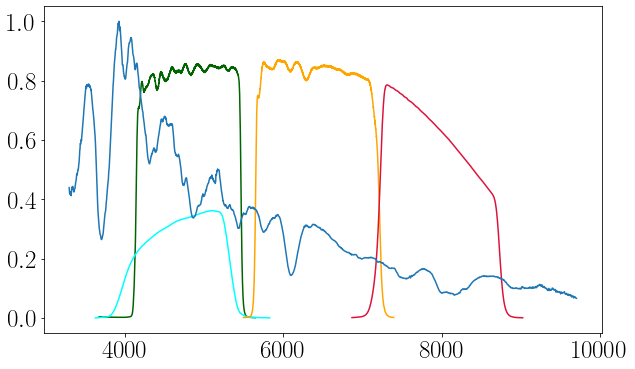

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(P48g[:, 0], P48g[:, 1], color='darkgreen')
plt.plot(SDSSg[:, 0], SDSSg[:, 1], color='cyan')
plt.plot(P48r[:, 0], P48r[:, 1], color='orange')
plt.plot(P48i[:, 0], P48i[:, 1], color='crimson')
plt.plot(wav, fl/np.max(fl))

## Synthetic Photometry

In [21]:
def spec_to_flux(spec, flt):
    wv, fl, sig = spec  # synthetic spectrum
    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    fl_flt = np.interp(x=wv_flt, xp=wv, fp=fl)
    var_flt = np.interp(x=wv_flt, xp=wv, fp=sig**2)
    # effective bandwidth
    width = ((wv_flt[1:] - wv_flt[:-1]) * (tra_flt[1:] + tra_flt[:-1]) /
             2).sum()
    # convolution
    flux = ((wv_flt[1:] - wv_flt[:-1]) * (fl_flt[1:] + fl_flt[:-1]) / 2 *
            (tra_flt[1:] + tra_flt[:-1]) / 2 /
            width).sum()  # erg cm-2 s-1 AA-1
    flux_err = ((wv_flt[1:] - wv_flt[:-1]) * (var_flt[1:] + var_flt[:-1]) / 2 *
                (tra_flt[1:] + tra_flt[:-1]) / 2 /
                width).sum()**.5  # erg cm-2 s-1 AA-1
    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    # effective bandwidth
    width = ((wv_flt[1:] - wv_flt[:-1]) * (tra_flt[1:] + tra_flt[:-1]) /
             2).sum()
    # effective wavelength
    wv_eff = ((wv_flt[1:] - wv_flt[:-1]) * (wv_flt[1:] + wv_flt[:-1]) / 2 *
              (tra_flt[1:] + tra_flt[:-1]) / 2 / width).sum()
    flux_Jy = (flux * u.erg / u.cm**2 / u.s / u.AA).to(
        u.Jy, equivalencies=u.spectral_density(wv_eff * u.AA))
    flux_err_Jy = flux_err / flux * flux_Jy
    return flux_Jy.value, flux_err_Jy.value

def spec_to_mag(spec, flt):
    flux, flux_err = spec_to_flux(spec, flt) # total flux in Jansky
    
    mag = -2.5 * np.log10(flux / 3631.1)
    mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2
    return mag, mag_unc


In [8]:
Mag, Mag_unc = np.empty((4, len(files))), np.empty((4, len(files)))
Fl, Fl_unc = np.empty((4, len(files))), np.empty((4, len(files)))
T_max, T_fl, MJD = [], [], []
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')
P48i = np.loadtxt('P48_I.dat')
SDSSg = np.loadtxt('SLOAN_SDSS.g.dat')
Flt = [P48g, P48r, P48i, SDSSg]
for j in range(len(files)):
    hdul = fits.open(files[j])
    hdr = hdul[0].header
    T_max = np.append(T_max, float(hdr['tmax']))
    T_fl = np.append(T_fl, float(hdr['txpl']))
    MJD = np.append(MJD, float(hdr['MJD']))
    fl, sig = hdul[0].data, hdul[1].data**.5
    wav = np.arange(len(fl)) * float(hdr['CDELT1']) + float(hdr['CRVAL1'])
    spec = np.array([wav, fl, sig])
    for k in range(4):
        Mag[k, j], Mag_unc[k, j] = spec_to_mag(spec, Flt[k])
        Fl[k, j], Fl_unc[k, j] = spec_to_flux(spec, Flt[k])
arg = np.argsort(T_max)
T_max, T_fl, MJD = T_max[arg], T_fl[arg], MJD[arg]
Mag, Mag_unc = Mag[:, arg], Mag_unc[:, arg]
Fl, Fl_unc = Fl[:, arg], Fl_unc[:, arg]

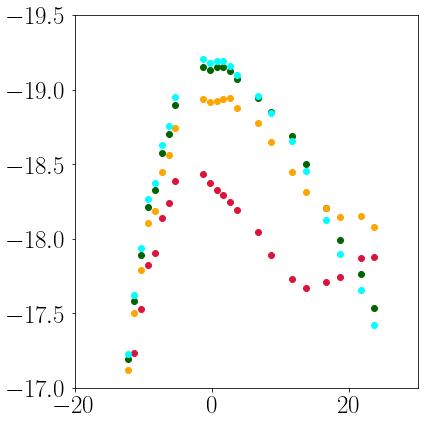

In [9]:
plt.figure(figsize=(6, 6))
plt.errorbar(T_max, Mag[0, :] - 29.04, yerr=Mag_unc[0, :], fmt='o', color='darkgreen')
plt.errorbar(T_max, Mag[1, :] - 29.04, yerr=Mag_unc[1, :], fmt='o', color='orange')
plt.errorbar(T_max, Mag[3, :] - 29.04, yerr=Mag_unc[3, :], fmt='o', color='cyan')
plt.scatter(T_max, Mag[2, :] - 29.04, color='crimson')
plt.xlim(-20, 30)
plt.ylim(-19.5, -17)
plt.gca().invert_yaxis()
plt.tight_layout()

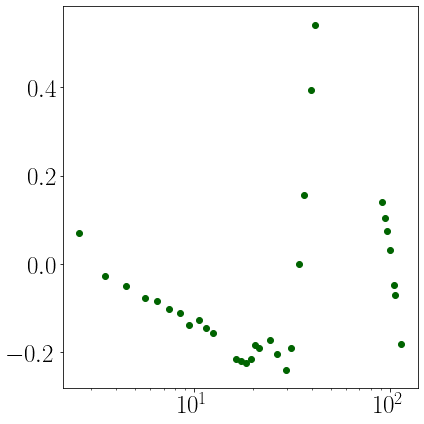

In [10]:
fl_g_r = Fl[0, :]/Fl[1, :]
fl_g_r_unc = (Fl_unc[0, :]**2 + Fl_unc[1, :]**2)**.5
g_r = -2.5 * np.log10(fl_g_r)
g_r_unc = -2.5 * np.log10((fl_g_r - fl_g_r_unc)/(fl_g_r + fl_g_r_unc)) / 2
plt.figure(figsize=(6, 6))
plt.errorbar(T_fl, g_r, yerr=g_r_unc, fmt='o', color='darkgreen')
plt.xscale('log')
plt.tight_layout()

In [11]:
np.savetxt('SN2011fe_g_synthetic.dat',
           np.array([MJD, Mag[0, :], Mag_unc[0, :]]).T)
np.savetxt('SN2011fe_r_synthetic.dat',
           np.array([MJD, Mag[1, :], Mag_unc[1, :]]).T)
np.savetxt('SN2011fe_g_r_synthetic.dat',
           np.array([MJD, g_r, g_r_unc]).T)

# DDet Models

In [32]:
with h5py.File('../../Mtot0.95/0.87_0.08_doubledet.h5', 'r') as f:
    print(list(f.keys()))
    Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
    Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
    time = np.array(f['time'][:] / 86400)
    nu = np.array(f['nu'][:])
    wv = np.flip((c.c / nu / u.Hz).to(u.AA).value)
    Flam = np.array([(np.flip(fnu)).to(u.erg / u.s / u.cm**2 / u.AA,
                     equivalencies=u.spectral_density(wv * u.AA)) for fnu in Fnu])

['Lnu', 'click', 'mu', 'mu_edges', 'nu', 'nu_edges', 'phi', 'phi_edges', 'time', 'time_edges']


In [39]:
Mag, Mag_unc = np.empty((3, len(time))), np.empty((3, len(time)))
Fl, Fl_unc = np.empty((3, len(time))), np.empty((3, len(time)))
T_fl = time
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')
P48i = np.loadtxt('P48_I.dat')
Flt = [P48g, P48r, P48i]
for j in range(len(time)):
    fl = Flam[j]
    if not (1 < time[j] < 40):
        Mag[:, j], Mag_unc[:, j] = np.nan, np.nan
        Fl[:, j], Fl_unc[:, j] = 0, 0
    else:
        spec = np.array([wv, fl, fl/100])
        for k in range(3):
            Mag[k, j], Mag_unc[k, j] = spec_to_mag(spec, Flt[k])
            Fl[k, j], Fl_unc[k, j] = spec_to_flux(spec, Flt[k])

Synthesized lc, 0.87 + 0.08, rmax at 20.35


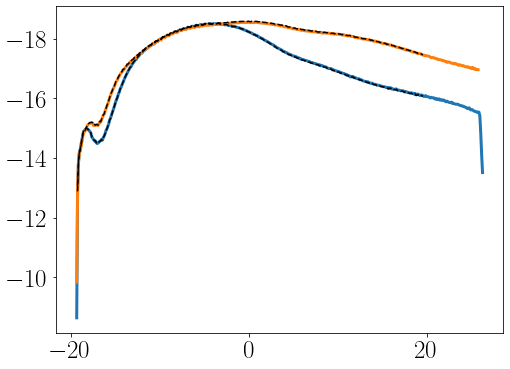

In [49]:
plt.figure(figsize=(8, 6))

model = glob.glob('../../Mtot0.95/*lightcurve.dat')
model.sort()

for mod in model:
    m = mod.split('/')[-1]
    m = m.split('_')
    mc, ms = m[0], m[1]
    dat = np.loadtxt(mod)
    dat = dat[dat[:, -1] != 0]
    T = dat[:, 0]
    g = dat[:, 3]
    r = dat[:, 4]
    if mc == '0.87':
        plt.plot(T[:-10] - T[np.argmin(r)],
                 g[:-10],
                 linewidth=3)  #g-band
        plt.plot(T[:-15] - T[np.argmin(r)],
                 r[:-15],
                 linewidth=3)
        print('Synthesized lc, {} + {}, rmax at {:.2f}'.format(
            mc, ms, T[np.argmin(r)]))

t_rmax = time[np.nanargmin(Mag[1])]
plt.plot(time - t_rmax, Mag[0], color='k', linestyle='--')
plt.plot(time - t_rmax, Mag[1], color='k', linestyle='--')

plt.gca().invert_yaxis()